In [3]:
import pandas as pd
import numpy as np
import os,cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model, Input

from keras.initializers import *

# Visualisation of dataset

To get a feel of the data, exploratory data analysis is done.

The total number of train images from each subdirectory are stored and used in the bar and pie charts

In [129]:
datasets = ["../input/plant-seedlings-classification/train"]

class_names = ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

nb_classes = len(class_names)
class_name_labels

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

Loading the train data into 2 lists *images* and *labels*, each storing the image and its corresponding labels. The labels in this case are the type of seedlings as recorded in the dataset.

In [130]:
from tqdm import tqdm

def load_data():
    images,labels = [],[]
    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(os.path.join(dataset,folder),file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img,(150,150))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)
        
        pass
    
    return images,labels
    pass

In [131]:
(train_images),(train_labels) = load_data()

100%|██████████| 231/231 [00:01<00:00, 173.53it/s]


Counting the number of images associated with each label.

In [132]:
n_train = train_labels.shape[0]

_, train_count = np.unique(train_labels,return_counts=True)

df = pd.DataFrame(data = train_count)
# df = df.T
df['Index'] = class_names
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


Creating a bar chart of train data using pandas *bar* function.

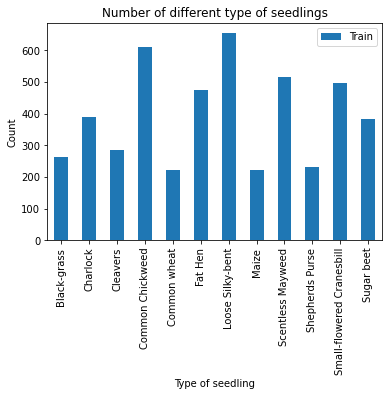

In [133]:
df.set_index("Name").plot.bar()
plt.xlabel("Type of seedling")
plt.ylabel("Count")
plt.title("Number of different type of seedlings");

As can be seen from the above bar chart that the maximum number of images belong to the class *Loose Silky-bent*, whatever that is. There is class imbalance with 5 classes having really low number of images while 2 classes have a high number of images with the rest around the median. 

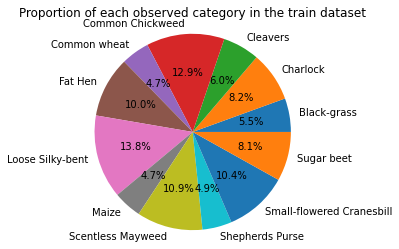

In [134]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0,0,0,0,0,0,0),
       labels = class_names,
       autopct = "%1.1f%%")
plt.axis('equal')
plt.title("Proportion of each observed category in the train dataset")
plt.show();

The class imbalance can also be inferred from the above pie chart, but this shows that it is not as steep as compared to the bar chart. It is advisable to normalize the count to give a better representation of the data present.

Creating a helper function for displaying the loss and accuracy versus epochs

In [135]:
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history["loss"],label="Loss")
    ax[0].plot(history.history["val_loss"],label="Test Loss")
    ax[1].plot(history.history["accuracy"],label="Accuracy")
    ax[1].plot(history.history["val_accuracy"],label="Test Accuracy")
    
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")

# Loading and Splitting Train Images

ImageDataGenerator from Keras is used for making the train dataset. Fora augmentation of images horizontal and vertical flip along with random rotation is used due to the low number of training images.

In [136]:
train_labels

array([8., 8., 8., ..., 9., 9., 9.], dtype=float32)

In [137]:
train_labels = to_categorical(train_labels,num_classes=nb_classes)

In [138]:
train_labels.shape

(4750, 12)

In [139]:
X_train,X_val,y_train,y_val = train_test_split(train_images,train_labels,test_size=0.3)

In [140]:
train_dir = "../input/plant-seedlings-classification/train"

batch_size = 16

IGD = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range=20)
#                         validation_split=0.3)

train_generator = IGD.flow(x=X_train,
                          y=y_train,
                          batch_size=batch_size,
                          shuffle=True,
                          seed=42)
#                           subset="training")

validation_generator = IGD.flow(x=X_val,
                               y=y_val,
                               batch_size=batch_size,
                               shuffle=True,
                               seed=42)
#                                subset="validation")

# Convolutional Block

Creating a Convolutional block for the model to make it easier to add more layers to the model without making major changes. This also allows for change in architecture without changing every line in the model. It also takes advantage of Python's OOP structure.

The block consists of:

`One convolutional layer with the user specifed filter size,kernel size, and lenght of strides.`
`One BatchNormalization Layer.`
`One Relu Activation Layer`

In [141]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'res_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + "_branch"
    
    F1 = filters
    
    X = Conv2D(filters=F1,kernel_size=(k,k),strides=(s,s),
              padding='same',name=conv_base_name,
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name)(X)
#     X = MaxPooling2D((3,3))(X)
    X = Activation('relu')(X)
    
    return X
    pass

# Creating the model

The current model consists of 4 convolutional layers and one fully connected layer, divided into various stages.

`Stage 1: Taking the input with kernel size = (5,5) and number of filters = 32.`
`Stage 2: Consists of 1 convolutional layer with a Relu activation and BatchNormalization.`
`Stage 3: Consists of 1 convolutional layer with a Relu activation and BatchNormalization.`
`Stage 4: Consists of 1 convolutional layer with a Relu activation and BatchNormalization.`

In [142]:
def conv_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(64,(5,5),strides=(2,2),name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
#     X = MaxPooling2D((3,3))(X)
#     X = Activation('relu')(X)
#     X = Dropout(0.1)(X)
    
    # Stage 2
    X = conv_block(X,5,64,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.1)(X)
    
    # Stage 3 
    X = conv_block(X,3,128,3,block='A',s=1)
    X = MaxPooling2D((3,3))(X)
    X = Dropout(0.1)(X)
    
    # Stage 4
    X = conv_block(X,5,256,4,block='A',s=1)
    X = Dropout(0.1)(X)
    
    # Output Layer
    X = Flatten()(X)
    X = Dense(256)(X)
    X = Dense(256)(X)
    X = Activation('relu')(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='CNN')
    
    return model
    pass

In [143]:
model = conv_model(input_shape=(150,150,3),classes=nb_classes)

Saving the model architecture as a flowchart for better understanding to *`conv_model.png`*

In [144]:
plot_model(model,to_file='conv_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 73, 73, 64)        4864      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 73, 73, 64)        256       
_________________________________________________________________
res_2A_branch (Conv2D)       (None, 73, 73, 64)        102464    
_________________________________________________________________
bn_2A_branch (BatchNormaliza (None, 73, 73, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0       

Using the Adam optimiser with learning rate set at 0.001 as this is currently giving the most optimal model.

In [145]:
opt = SGD(lr=0.0001,momentum=0.95)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

Storing the model's weights to *`model_weights.h5`*. This stores the best weights possible.

In [169]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,
                             save_best_only=True,mode="max")
callbacks_list = [checkpoint]

Running the model for 50 epochs

In [171]:
epochs = 10]2

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.n//batch_size,
                              callbacks=callbacks_list,
                              verbose=1)

Epoch 1/10
207/207 [==============================] - ETA: 0s - loss: 2.4162 - accuracy: 0.0532
Epoch 00001: val_accuracy improved from -inf to 0.04775, saving model to model_weights.h5
207/207 [==============================] - 196s 949ms/step - loss: 2.4162 - accuracy: 0.0532 - val_loss: 2.4341 - val_accuracy: 0.0478
Epoch 2/10
207/207 [==============================] - ETA: 0s - loss: 2.4310 - accuracy: 0.0490
Epoch 00002: val_accuracy did not improve from 0.04775
207/207 [==============================] - 198s 955ms/step - loss: 2.4310 - accuracy: 0.0490 - val_loss: 2.4359 - val_accuracy: 0.0471
Epoch 3/10
207/207 [==============================] - ETA: 0s - loss: 2.4310 - accuracy: 0.0490
Epoch 00003: val_accuracy did not improve from 0.04775
207/207 [==============================] - 195s 941ms/step - loss: 2.4310 - accuracy: 0.0490 - val_loss: 2.4341 - val_accuracy: 0.0478
Epoch 4/10
207/207 [==============================] - ETA: 0s - loss: 2.4318 - accuracy: 0.0487
Epoch 00004

In [159]:
# from tensorflow.keras.models import save_model
# save_model(model, "../input/plant-seedlings-classification/model_p.h5")
model.save_weights("../input/plant-seedlings-classification/model_weights.h5",r)

NameError: name 'r' is not defined

In [168]:
#../input/plant-seedlings-classification/train
model.load_weights("/kaggle/working/model_p.h5")
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

NameError: name 'X' is not defined

# Visualising the Loss and Accuracy of Model

Displaying the loss and accuracy versus epochs graph.

This graph allows the user to see whether the model needs to run for some more epochs or not.

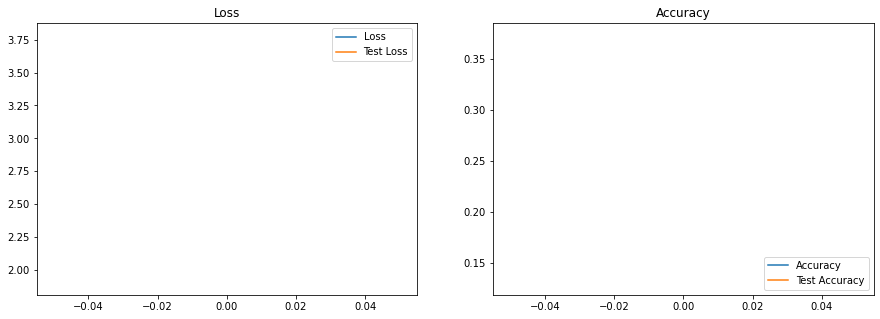

In [170]:
show_final_history(history)

The model is yet to reach the global minimum yet. At least the model is not overfitting which is a good thing. But its too bumpy, may need to change the momentum and learning rate for the optimizer.

# Plotting a Confusion Matrix

A confusion matrix is plotted below to see how well the model fared with respect to the train dataset. It will allow one to realize towards which class is the model biased against.

A threshold is set at half of the maximum correlation. Above that values are shown in white while below that are shown in black.

Bluer the shade of the block stronger the correlation between the predicted value and actual value. This type of matrix can also be shown for train data to show how the model fared there.

The model can be changed using this confusion matrix as a base calculation.

In [ ]:
class_name_labels

In [ ]:
y_test = np.argmax(y_val,axis=1)
y_test.shape,validation_generator.n

In [ ]:
val_pred = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in val_pred]

In [ ]:
y_pred = np.argmax(val_pred,axis=1)
y_pred.shape

In [ ]:
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.show()

The model is biased towards *Loose Silky Bent*

# Predicting the Test Images and making a submission

The test images are preprocessed via ImageDataGenerator and passed to the predict_generator function of the model for prediction. 

In [2]:
test_dir = ["/kaggle/input/plant-seedlings-classification/test"]

def load_test():
    
    images,names = [],[]
    for dataset in test_dir:

        for file in tqdm(os.listdir(dataset)):
            
            img_path = os.path.join(dataset,file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))

            images.append(img)
            names.append(file)
            pass
        
        images = np.array(images,dtype=np.float32)
        pass
    
    return images,names
    pass

In [ ]:
(test_images),(test_names) = load_test()

In [ ]:
for (label),(i) in class_name_labels.items():
    print(label,i)

In [ ]:
test_images[0].shape

In [ ]:
from keras.preprocessing.image import img_to_array

predicted_class = []
class_labels = dict((i,label) for label,i in class_name_labels.items())
for image in tqdm(test_images):
    
    image = np.expand_dims(image, axis=0)
    test_result = model.predict(image)
    pred_class = np.argmax(test_result,axis=1)
    prediction = [class_labels[k] for k in pred_class][0]
    predicted_class.append(prediction)
    pass

results = pd.DataFrame({"file":test_names,
                        "species":predicted_class})

In [ ]:
results.head()

In [ ]:
results.to_csv("submission.csv",index=False)

In [ ]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    pass